<a href="https://colab.research.google.com/github/zhueric2004/quant-assessment/blob/main/ConsumerComplaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Complaints Data Analysis

Import needed libraries


In [1]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 13.8 MB/s 
     |████████████████████████████████| 16.7 MB 46.1 MB/s 
     |████████████████████████████████| 6.3 MB 53.0 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Quant/consumer_complaints.csv")
populations = pd.read_csv("/content/drive/MyDrive/Quant/Populations.csv")
stateMap = gpd.read_file("/content/drive/MyDrive/Quant/tl_2021_us_state/tl_2021_us_state.shp")  
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [4]:
data.drop(['date_sent_to_company','date_received','consumer_consent_provided','complaint_id','company'], axis = 1, inplace = True)
data.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,state,zipcode,tags,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?
0,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,CA,95993,NaN,Referral,Closed with explanation,Yes,Yes
1,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,CA,91104,NaN,Referral,Closed with explanation,Yes,Yes
2,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,NY,11764,NaN,Postal mail,Closed with explanation,Yes,No
3,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,MD,21402,NaN,Email,Closed with explanation,Yes,Yes
4,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,GA,30106,NaN,Web,Closed with explanation,Yes,Yes


In [5]:
stateMap = stateMap.drop([34,35,36,41])

In [7]:
stateMap.drop(['REGION','DIVISION','STATEFP','STATENS','GEOID', 'LSAD', 'MTFCC', 'FUNCSTAT','ALAND', 'AWATER'], axis = 1, inplace = True)
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428..."
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067..."
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295..."
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373..."


In [9]:
def frequencyToDataframe(df, column):
  return df[column].value_counts().to_frame()

In [10]:
def merge(shapefile, df, column):
  return shapefile.merge(df, on=column)

In [11]:
def frequencyByState(df, newName, stateMap):
  df.index.names = ['STUSPS']
  df.rename({'state': newName}, axis='columns', inplace = True)
  stateMap = stateMap.merge(df, on='STUSPS')
  return stateMap

In [12]:
stateFreq = frequencyToDataframe(data, 'state')
stateMap = frequencyByState(stateFreq, 'total', stateMap)

In [13]:
type(stateMap)
stateMap.head()


,STUSPS,NAME,INTPTLAT,INTPTLON,geometry,total
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428...",1457
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",53673
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067...",19624
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295...",6424
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373...",17703


In [14]:
stateMap = stateMap.merge(populations, on = 'NAME')

In [15]:
stateMap['Population'] = stateMap['Population'].str.replace(',', '').astype(float)
stateMap["proportion"] = stateMap["total"]/stateMap["Population"] * 100
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry,total,Population,proportion
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428...",1457,1782959.0,0.081718
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",53673,21781128.0,0.246420
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067...",19624,12671469.0,0.154868
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295...",6424,5707390.0,0.112556
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373...",17703,6165129.0,0.287147


In [16]:
def choropleth(column, label, title): 
  fig, ax = plt.subplots(figsize=(25, 10))
  stateMap.plot(column=column, 
              legend = True, ax = ax,
              edgecolor="white",
              legend_kwds={'label': title,
                        'orientation': "vertical"})
  ax.set_xlim(-130, -63)
  ax.set_ylim(23, 50)
  ax.set_title(label)

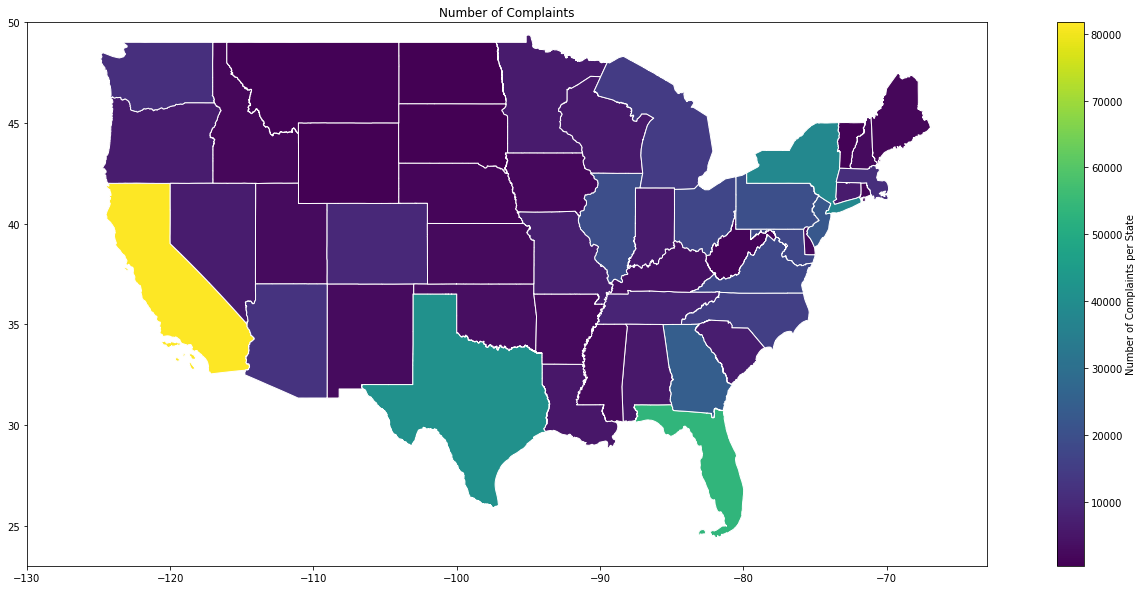

In [17]:
choropleth('total', 'Number of Complaints', 'Number of Complaints per State')

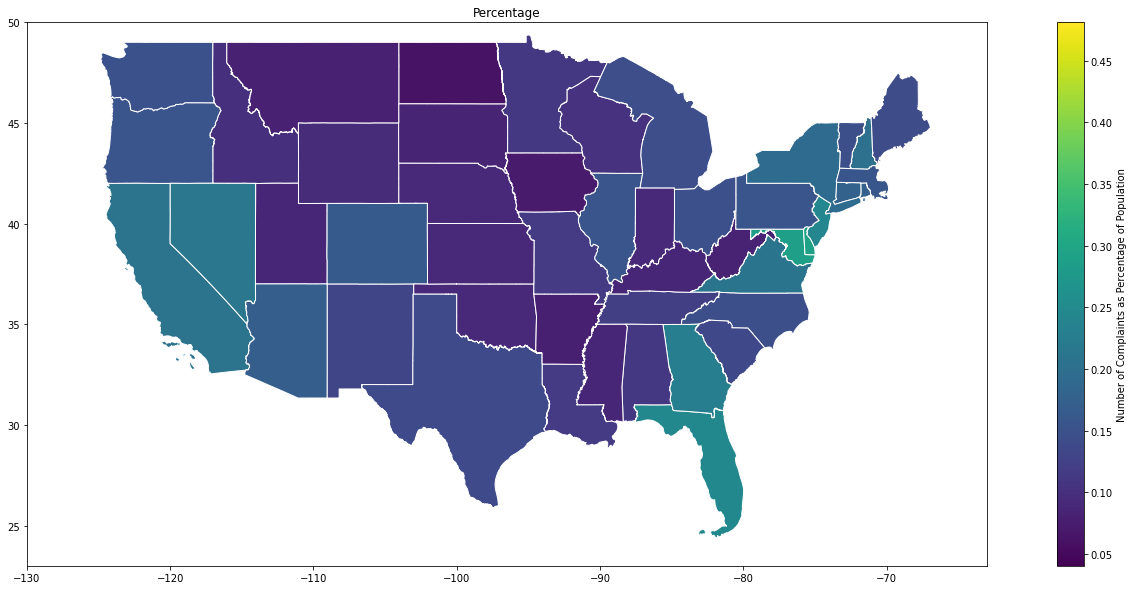

In [19]:
choropleth('proportion', 'Percentage', 'Number of Complaints as Percentage of Population')

In [21]:
disputed = data.loc[(data['consumer_disputed?']  == 'Yes')]
disputed = frequencyToDataframe(disputed, 'state')
stateMap = frequencyByState(disputed, 'disputes', stateMap)

In [22]:
notDisputed = data.loc[(data['consumer_disputed?']  == 'No')]
notDisputed = frequencyToDataframe(notDisputed, 'state')
stateMap = frequencyByState(notDisputed, 'nonDisputes', stateMap)

In [23]:
stateMap["disputesPerCapita"] = stateMap["disputes"] / stateMap["Population"] * 100
stateMap["percentDisputed"] = stateMap["disputes"] / stateMap["nonDisputes"] * 100

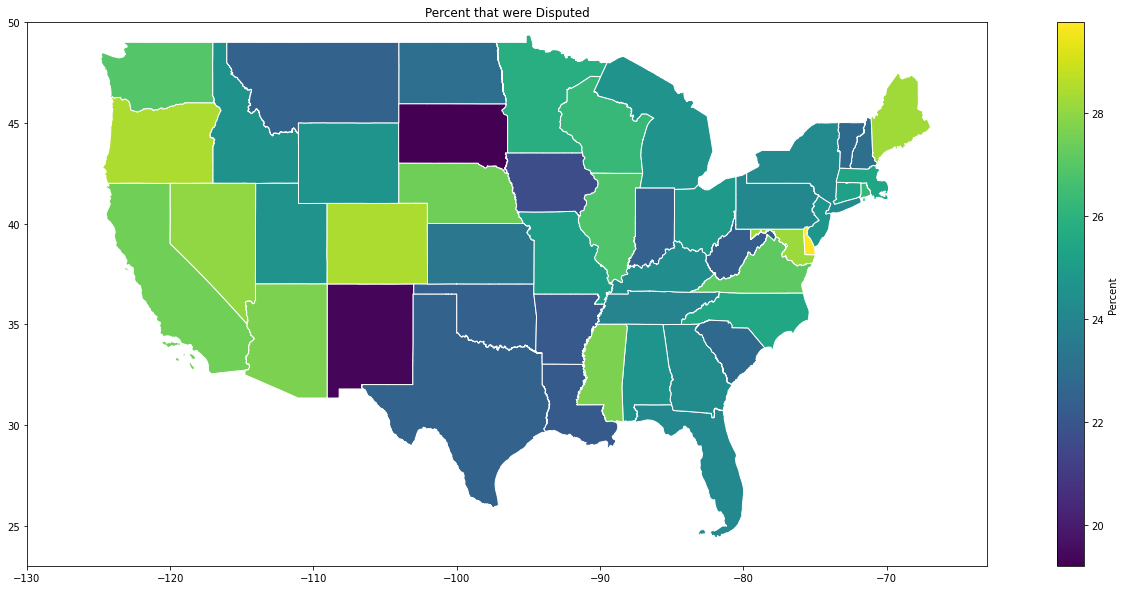

In [27]:
choropleth('percentDisputed', 'Percent that were Disputed', 'Percent')